In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import datetime
import urllib

Copied from:

https://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/

In [2]:
data = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4,9
2012-10-03 01:00:00,4,6
2012-10-03 02:00:00,1,1
2012-10-03 03:00:00,2,3
2012-10-03 04:00:00,6,1


In [3]:
data.columns = ['West','East']
data.fillna(0,inplace=True)
data['Total'] = data.eval('East + West')

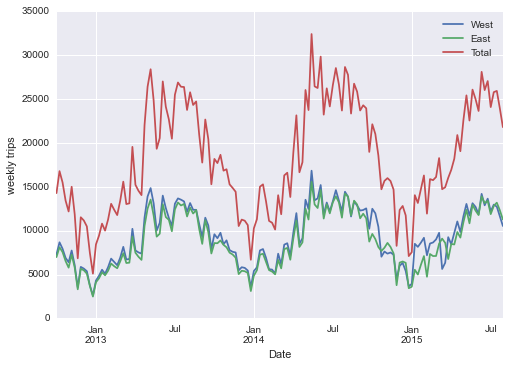

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import numpy as np

data.resample('W',how='sum').plot()
plt.ylabel('weekly trips')

In [5]:
pivoted = data.pivot_table(['East','West'],
                          index = data.index.date,
                          columns = data.index.hour,
                          fill_value=0)
pivoted.head()

East                                    ... West                 \
             0  1  2  3  4   5   6    7    8    9  ...   14   15   16   17   
2012-10-03    9  6  1  3  1  10  50   95  146  104 ...   77   72  133  192   
2012-10-04   11  0  6  3  1  11  51   89  134   94 ...   63   73  114  154   
2012-10-05    7  4  3  2  2   7  37  101  119   81 ...   63   80  120  144   
2012-10-06    7  5  2  2  1   2  15   16   47   55 ...   89  115  107  107   
2012-10-07    5  5  1  2  2   3   8   12   26   36 ...  126  122  132  118   

                                     
             18  19  20  21  22  23  
2012-10-03  122  59  29  25  24   5  
2012-10-04  137  57  27  31  25  11  
2012-10-05  107  42  27  11  10  16  
2012-10-06   41  40  25  18  14  15  
2012-10-07   68  26  19  12   9   5  

[5 rows x 48 columns]

In [6]:
X = pivoted.values
X.shape

(1032L, 48L)

In [7]:
from sklearn.decomposition import PCA
Xpca = PCA(0.9).fit_transform(X)
Xpca.shape

(1032L, 2L)

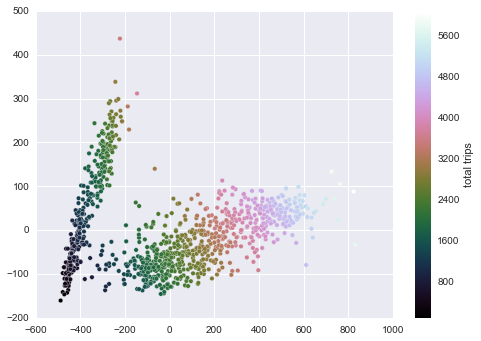

In [8]:
total_trips = X.sum(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips,
            cmap='cubehelix')
plt.colorbar(label='total trips');

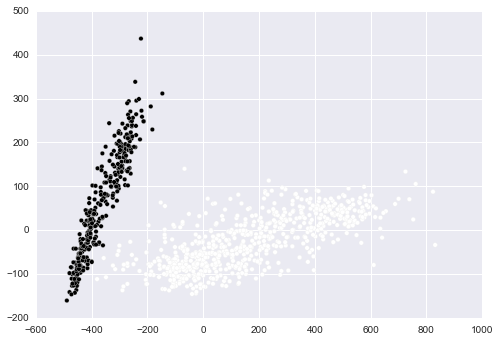

In [9]:
from sklearn.mixture import GMM
gmm = GMM(2, covariance_type='full', random_state=0)
gmm.fit(Xpca)
cluster_label = gmm.predict(Xpca)
plt.scatter(Xpca[:,0],Xpca[:,1],c=cluster_label)

In [10]:
pivoted['Cluster'] = cluster_label
data = data.join(pivoted['Cluster'],on=data.index.date)
data.head()

,West,East,Total,Cluster
Date,,,,
2012-10-03 00:00:00,4,9,13,0
2012-10-03 01:00:00,4,6,10,0
2012-10-03 02:00:00,1,1,2,0
2012-10-03 03:00:00,2,3,5,0
2012-10-03 04:00:00,6,1,7,0


In [11]:
by_hour = data.groupby(['Cluster',data.index.time]).mean()
by_hour.head()

West      East      Total
Cluster                                        
0       00:00:00  5.368347  6.305322  11.673669
        01:00:00  2.752101  3.033613   5.785714
        02:00:00  2.305322  1.775910   4.081232
        03:00:00  1.600840  1.462185   3.063025
        04:00:00  4.229692  2.698880   6.928571

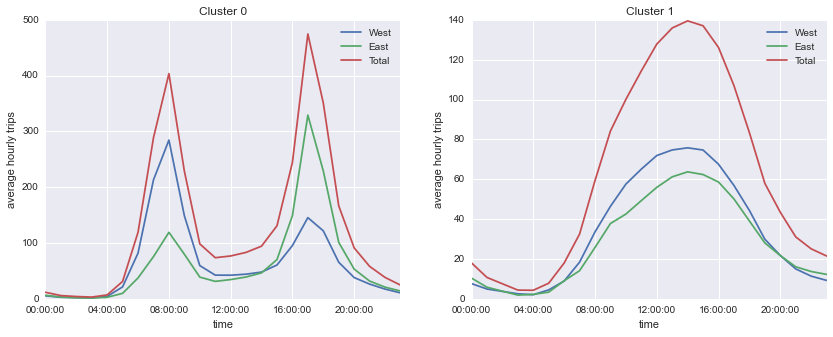

In [12]:
fig, ax = plt.subplots(1,2,figsize = (14,5))
hourly_ticks = 4*60*60*np.arange(6)

for i in range(2):
    by_hour.ix[i].plot(ax=ax[i], xticks=hourly_ticks)
    ax[i].set_title('Cluster {0}'.format(i))
    ax[i].set_ylabel('average hourly trips')
    

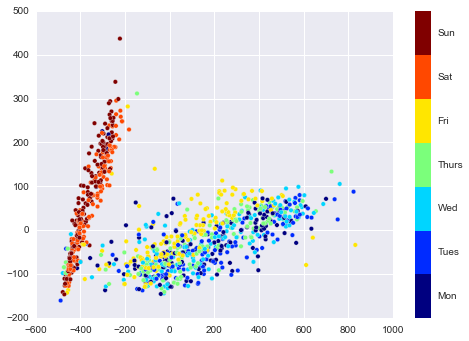

In [13]:
dayofweek = pd.to_datetime(pivoted.index).dayofweek
plt.scatter(Xpca[:,0],Xpca[:,1], c=dayofweek,
           cmap=plt.cm.get_cmap('jet',7))
cb=plt.colorbar(ticks=range(7))
cb.set_ticklabels(['Mon','Tues','Wed','Thurs','Fri','Sat',
                  'Sun'])
plt.clim(-0.5,6.5)

In [16]:
results = pd.DataFrame({'cluster': cluster_label,
                        'is_weekend': (dayofweek > 4),
                        'weekday': pivoted.index.map(lambda x: x.strftime('%a'))},
                       index=pivoted.index)
results.head()

,cluster,is_weekend,weekday
2012-10-03,0,False,Wed
2012-10-04,0,False,Thu
2012-10-05,0,False,Fri
2012-10-06,1,True,Sat
2012-10-07,1,True,Sun


In [17]:
weekend_workdays = results.query('cluster == 0 and is_weekend')
len(weekend_workdays)

0

In [18]:
midweek_holidays = results.query('cluster == 1 and not is_weekend')
len(midweek_holidays)

24

In [30]:
midweek_holidays.head()

,cluster,is_weekend,weekday
2012-11-22,1,False,Thu
2012-11-23,1,False,Fri
2012-12-24,1,False,Mon
2012-12-25,1,False,Tue
2013-01-01,1,False,Tue


In [19]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016', return_name=True)
holidays.head()

2012-01-02                 New Years Day
2012-01-16    Dr. Martin Luther King Jr.
2012-02-20                Presidents Day
2012-05-28                   MemorialDay
2012-07-04                      July 4th
dtype: object

In [23]:
holidays_all = pd.concat([holidays,
                         "Day Before " + holidays.shift(-1, 'D'),
                         "Day After " + holidays.shift(1, 'D')])
holidays_all = holidays_all.sort_index()
holidays_all.head()

2012-01-01                 Day Before New Years Day
2012-01-02                            New Years Day
2012-01-03                  Day After New Years Day
2012-01-15    Day Before Dr. Martin Luther King Jr.
2012-01-16               Dr. Martin Luther King Jr.
dtype: object

In [27]:
holidays_all.name = 'name'

In [29]:
holidays_all.name

'name'

In [31]:
holidays_all.name = 'name'  # required for join
joined = midweek_holidays.join(holidays_all)
set(joined['name'])

{'Christmas',
 'Day After Christmas',
 'Day After Thanksgiving',
 'Day Before Christmas',
 'July 4th',
 'Labor Day',
 'MemorialDay',
 'New Years Day',
 'Thanksgiving'}

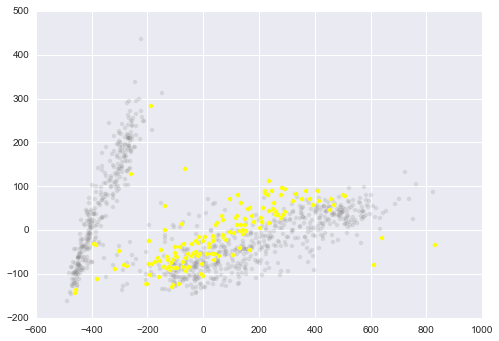

In [35]:
fridays = (dayofweek == 4)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c='gray', alpha=0.2)
plt.scatter(Xpca[fridays, 0], Xpca[fridays, 1], c='yellow');

In [38]:
weird_fridays = pivoted.index[fridays & (Xpca[:, 0] > 600)]
weird_fridays

Index([2013-05-17, 2014-05-16, 2015-05-15], dtype='object')

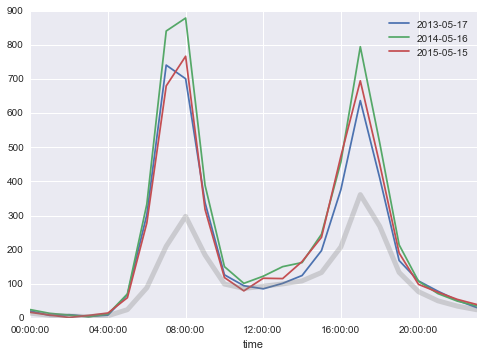

In [39]:
all_days = data.pivot_table('Total', index=data.index.time, columns=data.index.date)
all_days.loc[:, weird_fridays].plot();
all_days.mean(1).plot(color='gray', lw=5, alpha=0.3,
                      xticks=hourly_ticks);